# Diffusion pseudotime on thymocytes

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata2ri
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]

sc.settings.set_figure_params(dpi=100, color_map='Blues')

In [72]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

### Import data 

In [3]:
adata_F74_1 = sc.read_10x_mtx('/home/jovyan/my_data/Human_colon_16S7985396/', cache=True)
adata_F74_2 = sc.read_10x_mtx('/home/jovyan/my_data/Human_colon_16S7985397/', cache=True)

In [4]:
## Rename matching annotation in ATAC data
adata_F74_1.obs_names = [i.split('-')[0]+'_1' for i in adata_F74_1.obs_names]
adata_F74_2.obs_names = [i.split('-')[0]+'_2' for i in adata_F74_2.obs_names]

### Preprocessing

Taken from Cecilia's notebook

1. Filter cells with high mitochondrial counts

In [78]:
mito_genes = [name for name in adata_F74_1.var_names if name.startswith('MT-')]
#the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata_F74_1.obs['percent_mito'] = np.sum(adata_F74_1[:, mito_genes].X, axis=1).A1 / np.sum(adata_F74_1.X, axis=1).A1

mito_genes = [name for name in adata_F74_2.var_names if name.startswith('MT-')]
adata_F74_2.obs['percent_mito'] = np.sum(adata_F74_2[:, mito_genes].X, axis=1).A1 / np.sum(adata_F74_2.X, axis=1).A1

2. Filter cells w low counts

In [79]:
adata_F74_1.obs['n_counts'] = adata_F74_1.X.sum(axis=1).A1
adata_F74_2.obs['n_counts'] = adata_F74_2.X.sum(axis=1).A1

sc.pp.filter_cells(adata_F74_1, min_genes=600)
sc.pp.filter_cells(adata_F74_1, min_counts=1000)

sc.pp.filter_cells(adata_F74_2, min_genes=600)
sc.pp.filter_cells(adata_F74_2, min_counts=1000)


In [91]:
adata = adata_F74_1.concatenate(adata_F74_2, join='outer',index_unique=None)

3. Normalize

In [92]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

4. Log transform

In [93]:
sc.pp.log1p(adata)
adata.raw = adata

7. Add annotation provided by Cecilia

In [94]:
annotation = pd.read_csv("/home/jovyan/my_data/F74_RNA_obs_v2.csv", index_col=0)
## Rename matching annotation in ATAC data
annotation.index = [annotation.index[i].split("_")[2]+"_1" if annotation.batch.tolist()[i]==0 else annotation.index[i].split("_")[2]+"_2" for i in range(0,len(annotation.index))]

adata.obs = pd.concat([adata.obs,annotation[['anno_v2', 'annotation']]], axis=1, join="outer")


Save data as SingleCellExperiment

In [95]:
%%R -i adata
saveRDS(adata, "~/my_data/F74_RNA_scanpy_preprocessed.RDS")

Load SingleCellExperiment object

In [99]:
%%R -o adata
adata <- readRDS("/home/jovyan/my_data/integrated_thymus/F74_SCElist_20191113.RDS")[["RNA"]]

#### Visualization

In [108]:
adata.X = adata.layers["logcounts"]

5. Select HVGs

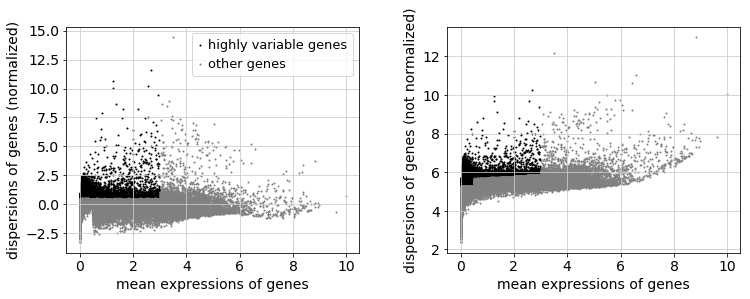

In [126]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

# adata_hvg = adata[:, adata.var['highly_variable']]

6. Regress out technical effects

In [112]:
# sc.pp.regress_out(adata_hvg, ['n_counts', 'percent_mito'])

KeyError: "None of [Index(['n_counts', 'percent_mito'], dtype='object')] are in the [columns]"

In [121]:
adata_hvg.obs = adata_hvg.obs.astype({'annotation':'category'})

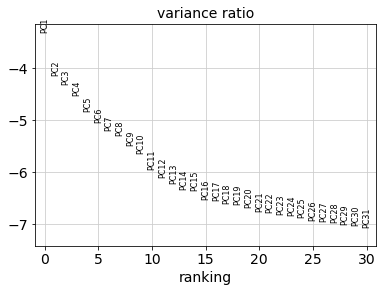

In [122]:
sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg)
sc.pl.pca_variance_ratio(adata_hvg, log=True)

In [124]:
sc.pp.neighbors(adata_hvg, n_pcs=40)
sc.tl.umap(adata_hvg)
sc.tl.leiden(adata_hvg)

/home/jovyan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


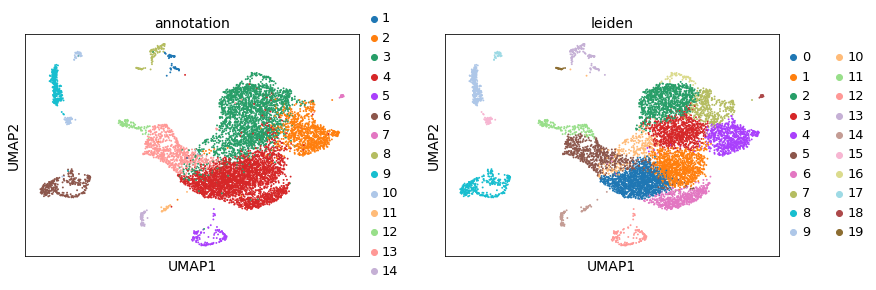

In [125]:
sc.pl.umap(adata_hvg, color=['annotation', "leiden"], ncols=2)

#### Save AnnData 

In [ ]:
results_file = '~/my_data/F74_RNA_scanpy_preprocessed.h5ad'
adata.write(results_file, compression='gzip')  

### Trajectory analysis on T-cells

Using diffusion pseudotime (as in JPs paper)

Subset to T-cell clusters

In [370]:
# tcellsATAC = range(1,6)
tcellsRNA = ["DN", "DP (Q)", "DP (P)", "SP"]

adataTcells = adata[adata.obs['anno_v2'].isin(tcellsRNA),]

Calculate neighborhoods

In [371]:
sc.pp.neighbors(adataTcells, n_neighbors=10, method="gauss", knn=False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Run diffusion map algorithm 

In [372]:
sc.tl.diffmap(adataTcells)

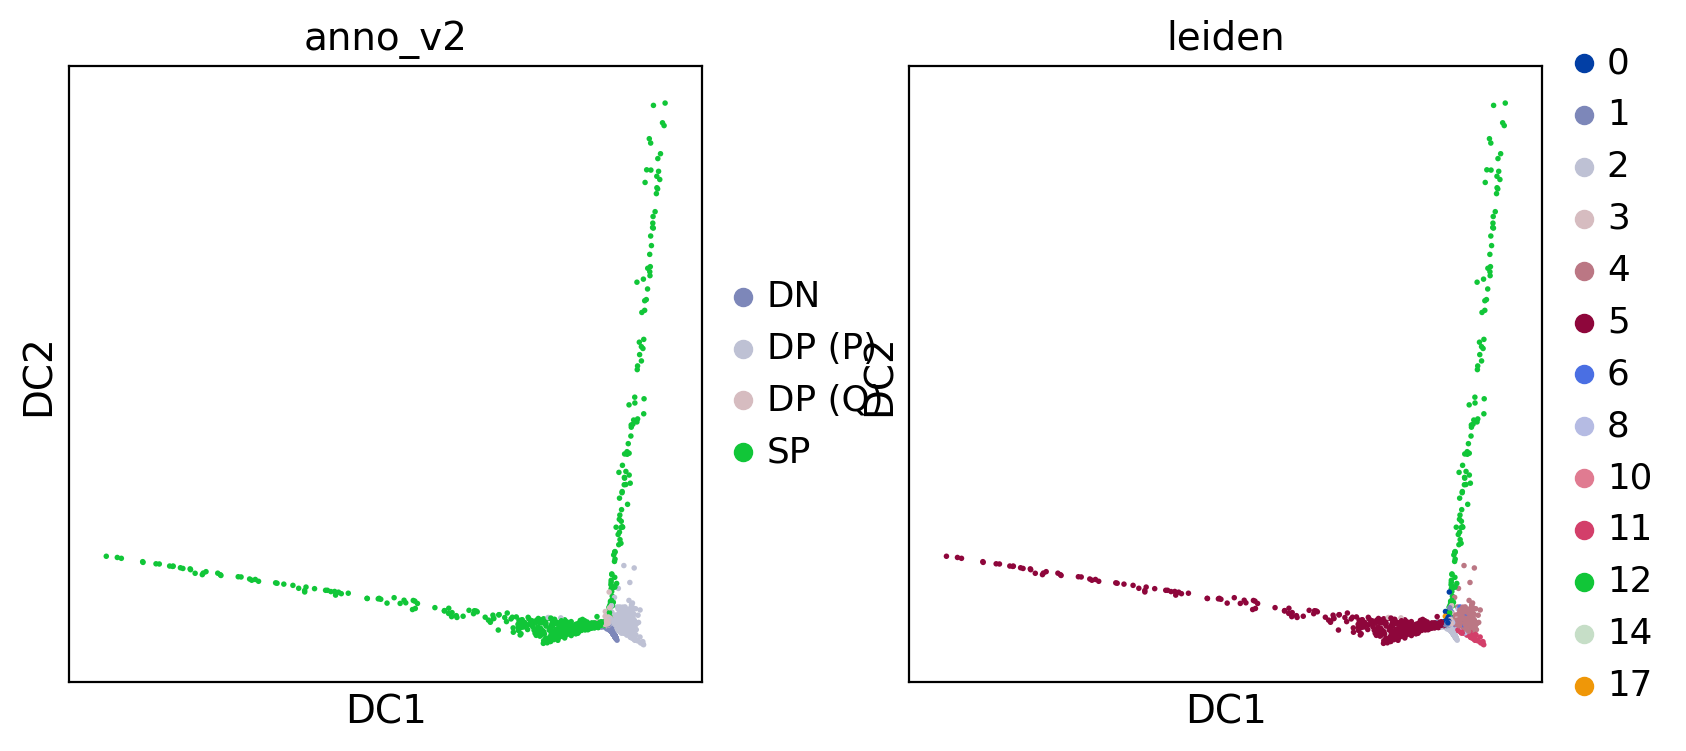

In [373]:
sc.pl.diffmap(adataTcells, color=["anno_v2", "leiden"])

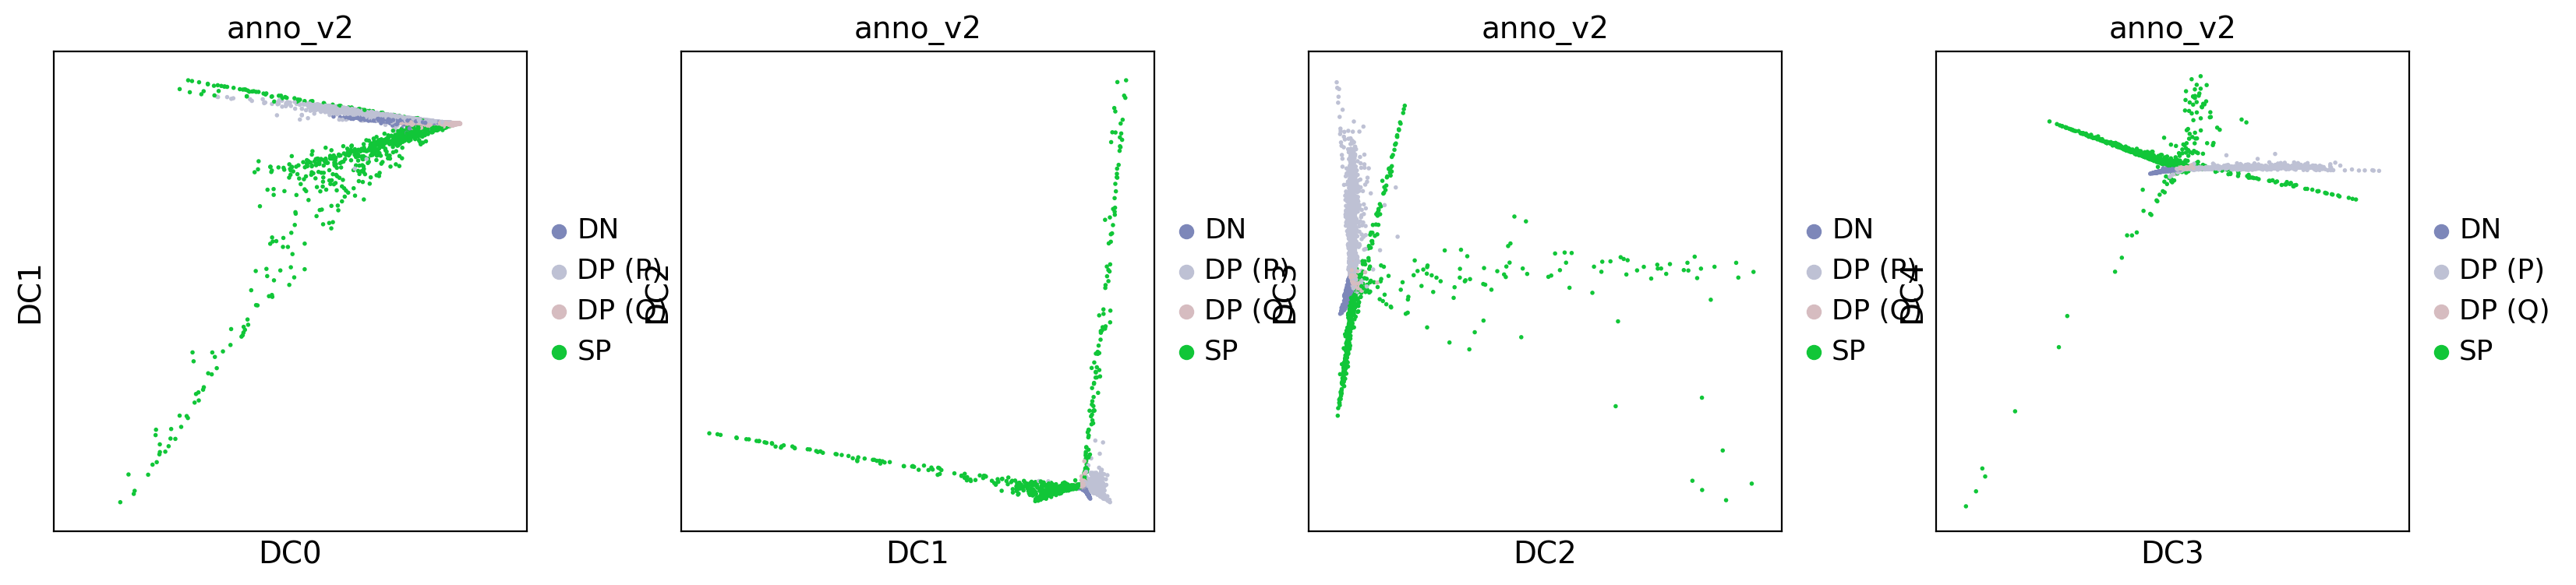

In [376]:
sc.pl.diffmap(adataTcells, color=["anno_v2"], components=['0,1', '1,2', '2,3', "3,4"])

Find root cell among the Double Negatives

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


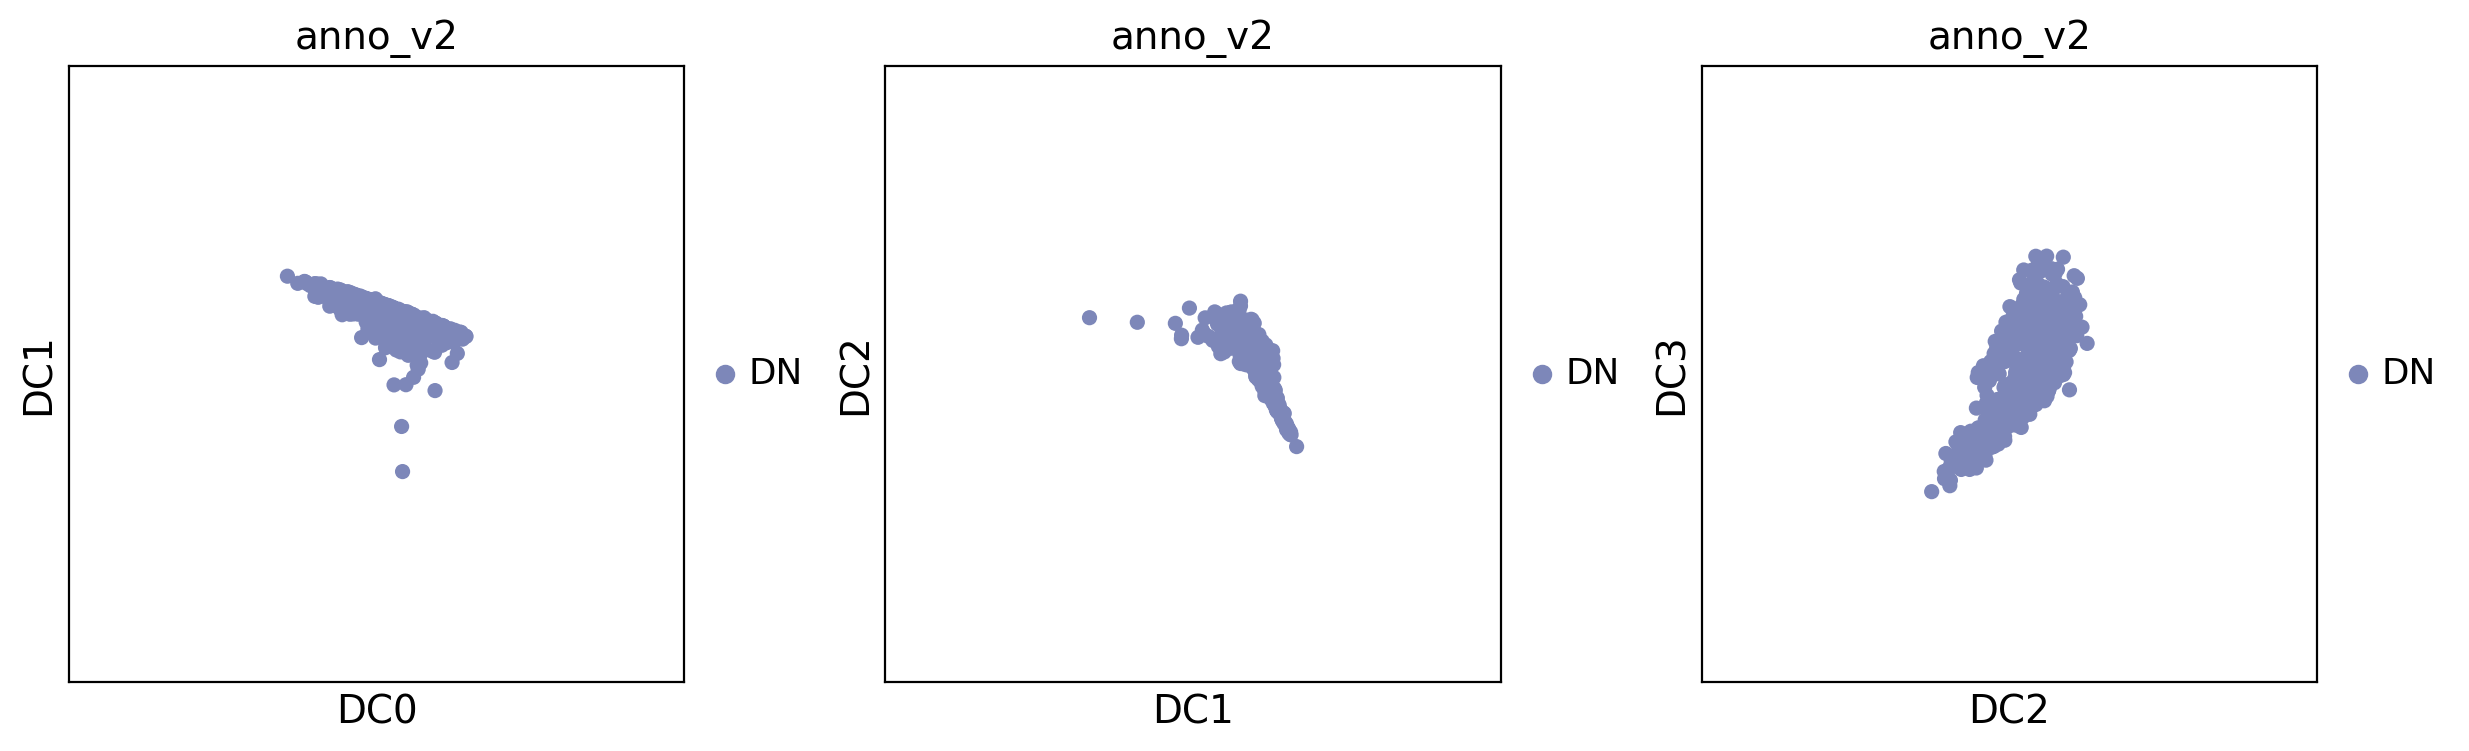

In [377]:
sc.pl.diffmap(adataTcells[adataTcells.obs.anno_v2=="DN"], color=["anno_v2"], components=['0,1', '1,2', '2,3'])

In [378]:
DN_diffmap = adataTcells[adataTcells.obs.anno_v2=="DN"].obsm["X_diffmap"]

iroot = np.where(DN_diffmap[:,[2]] == np.amin(DN_diffmap[:,[2]]))[0][0]
root = adataTcells.obs.iloc[iroot].name

In [379]:
adataTcells.var['xroot'] = adataTcells[root, :].X

/home/jovyan/.local/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


Run pseudotime

In [381]:
sc.tl.dpt(adataTcells, n_branchings=0, n_dcs=4)

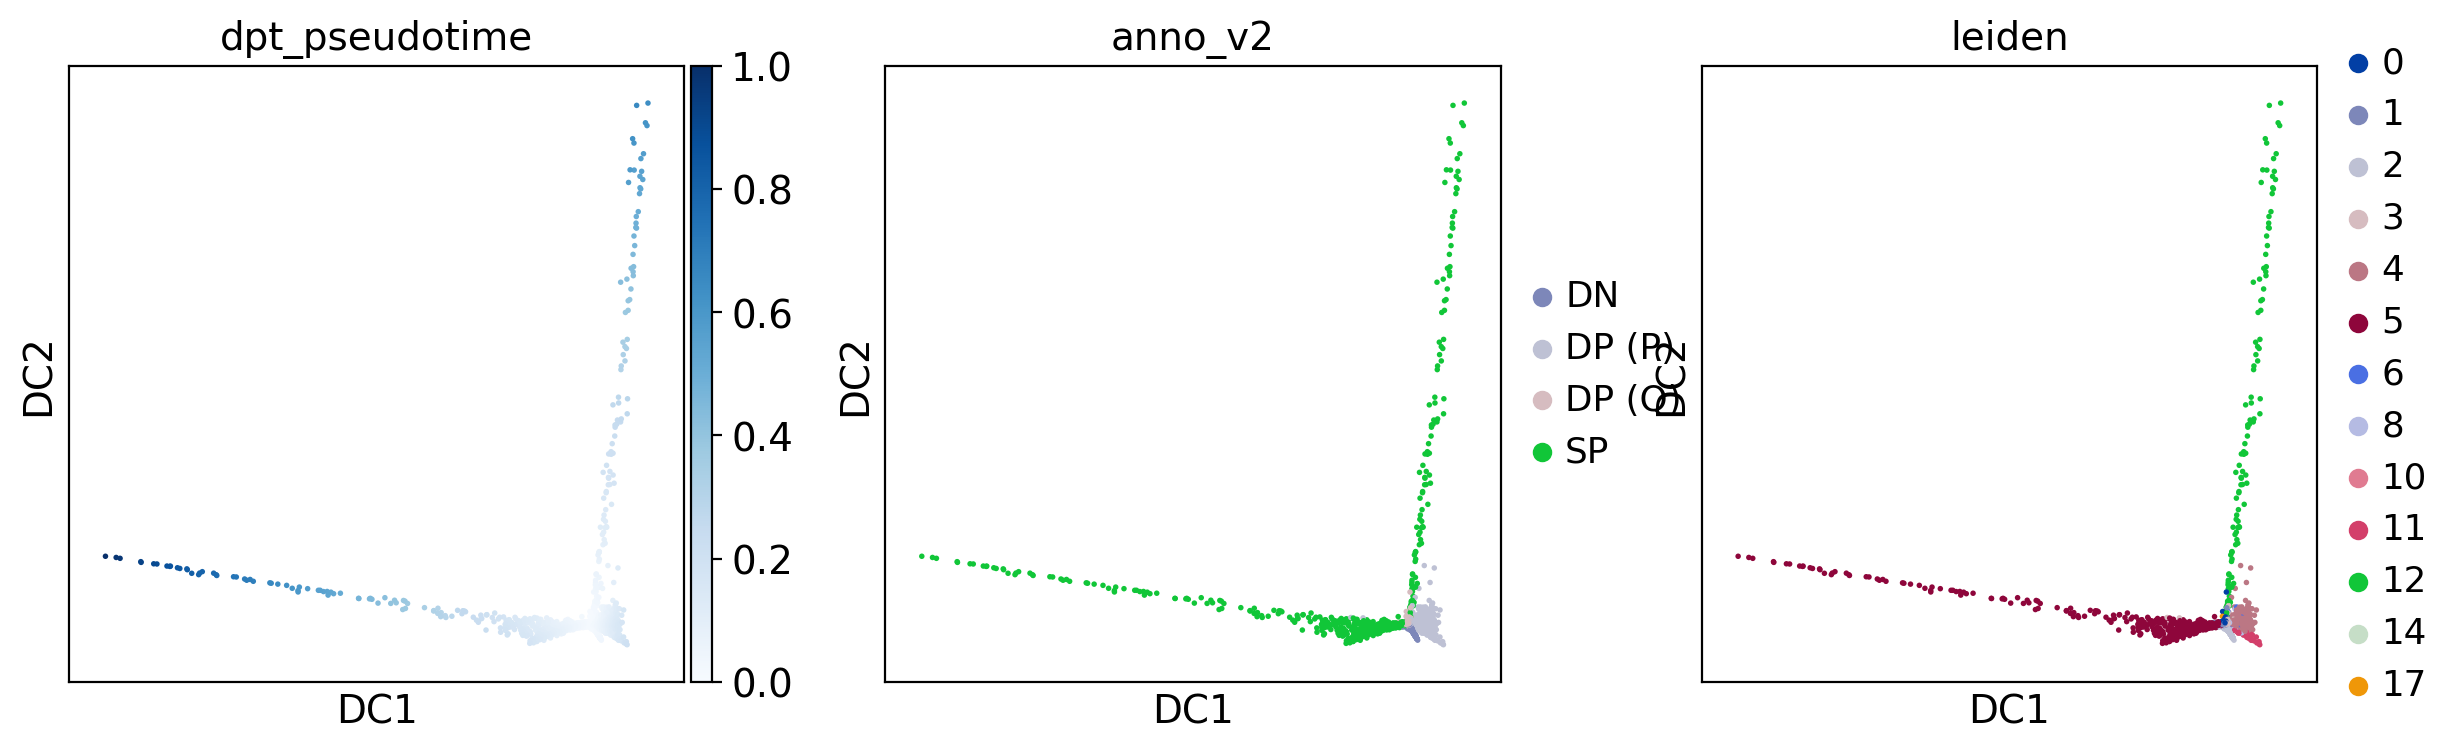

In [385]:
sc.pl.diffmap(adataTcells, color=["dpt_pseudotime",'anno_v2', 'leiden'])

Save diffusion pseudotime 

In [277]:
adataTcells.obs.to_csv("/home/jovyan/models/scanpy_RNA_pseudotime.csv")